In [1]:
import zipfile
import os
import pandas as pd
import requests
import deflatebr as dbr
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def concatenar_csvs(diretorio):
    frames = []

    for arquivo in os.listdir(diretorio):
        if arquivo.endswith('.csv'):
            caminho_arquivo = os.path.join(diretorio, arquivo)
            
            df = pd.read_csv(caminho_arquivo, encoding='utf-8', delimiter=";", decimal=",")
            df = df.rename(columns={df.columns[0]: "data_base"})
            df = df[df['cliente'] == "PF"]
            df['porte'] = df['porte'].str.replace(' ','')
            df['porte']=df['porte'].str.replace('PF-','')
            df = df.iloc[:, [0, 8, 20, 22]]
            df['data_base'] = pd.to_datetime(df['data_base'], format="%Y-%m-%d")
            df['mes'] = df['data_base'].dt.month
            df = df[df['mes'] == 12]
            
            frames.append(df)

    df_concatenado = pd.concat(frames, ignore_index=True)

    return df_concatenado

In [3]:
anos = list(range(2012, 2024))
dataframes = []

for ano in anos:
    diretorio = f"planilha_{ano}"
    dataframe_ano = concatenar_csvs(diretorio)
    dataframes.append(dataframe_ano)

df_total = pd.concat(dataframes, ignore_index=False)

In [4]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 935619 entries, 0 to 136400
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   data_base           935619 non-null  datetime64[ns]
 1   porte               935619 non-null  object        
 2   carteira_ativa      935619 non-null  float64       
 3   ativo_problematico  935619 non-null  float64       
 4   mes                 935619 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), object(1)
memory usage: 39.3+ MB


In [5]:
portes = {
    'Acimade20saláriosmínimos': 'Acima de 20 salários mínimos',
    'Até1saláriomínimo': 'Até 1 salário mínimo',
    'Indisponível': 'Indisponível',
    'Maisde10a20saláriosmínimos': 'Mais de 10 a 20 salários mínimos',
    'Maisde1a2saláriosmínimos': 'Mais de 1 a 2 salários mínimos',
    'Maisde2a3saláriosmínimos': 'Mais de 2 a 3 salários mínimos',
    'Maisde3a5saláriosmínimos': 'Mais de 3 a 5 salários mínimos',
    'Maisde5a10saláriosmínimos': 'Mais de 5 a 10 salários mínimos',
    'Semrendimento': 'Sem rendimento'
}

for porte_sem_espaco, porte_com_espaco in portes.items():
    df_total['porte'] = df_total['porte'].str.replace(porte_sem_espaco, porte_com_espaco)

In [191]:
def categoria_renda(dados_porte):
    if dados_porte in ['Acima de 20 salários mínimos', 'Mais de 10 a 20 salários mínimos', 'Mais de 3 a 5 salários mínimos']:
        return 'alta renda'
    elif dados_porte == 'Indisponível':
        return 'renda indisponível'
    elif dados_porte == 'Mais de 5 a 10 salários mínimos':
        return 'renda média'
    else:
        return 'baixa renda'

df_total['categoria_renda'] = df_total['porte'].apply(categoria_renda)

In [192]:
df_total_group = df_total.groupby(['data_base', 'categoria_renda'])[['carteira_ativa', 'ativo_problematico']].sum().reset_index()

In [193]:
df_total_group.head(5)

,data_base,categoria_renda,carteira_ativa,ativo_problematico
0,2012,alta renda,4.951145e+11,3.297373e+10
1,2012,baixa renda,3.477084e+11,3.626865e+10
2,2012,renda indisponível,4.338362e+09,3.721765e+08
3,2012,renda média,1.869864e+11,1.515055e+10
4,2013,alta renda,6.019103e+11,3.723825e+10


In [194]:
df_pivot = df_total_group.pivot_table(index="data_base",
                                      columns='categoria_renda', 
                                      values=['carteira_ativa', 'ativo_problematico'],
                                      aggfunc='sum').reset_index()

df_pivot.columns = ['_'.join(col).rstrip('_') for col in df_pivot.columns.values] #para que as colunas não sejam multinível

In [195]:
df_pivot.head(5)

,data_base,ativo_problematico_alta renda,ativo_problematico_baixa renda,ativo_problematico_renda indisponível,ativo_problematico_renda média,carteira_ativa_alta renda,carteira_ativa_baixa renda,carteira_ativa_renda indisponível,carteira_ativa_renda média
0,2012,3.297373e+10,3.626865e+10,3.721765e+08,1.515055e+10,4.951145e+11,3.477084e+11,4.338362e+09,1.869864e+11
1,2013,3.723825e+10,3.743314e+10,2.895474e+08,1.703012e+10,6.019103e+11,3.849078e+11,2.097316e+09,2.163200e+11
2,2014,3.976619e+10,3.700319e+10,2.104486e+08,1.742195e+10,7.093165e+11,4.180637e+11,1.118568e+09,2.566271e+11
3,2015,4.603043e+10,4.115531e+10,1.923223e+08,1.881933e+10,7.606288e+11,4.430292e+11,6.614035e+08,2.723605e+11
4,2016,4.814152e+10,4.870744e+10,2.586311e+07,2.059768e+10,7.420125e+11,5.249931e+11,1.841053e+08,2.813986e+11


In [ ]:
df_pivot['data_base'] = df_pivot['data_base'].dt.strftime('%Y') #Converti apenas para o ano porque algumas das séries que vou usar do bacen são anuais

In [11]:
#Extraindo informações do Sistema Gerenciador de Séries Temporais do BCB
codigos_series = [24868, 24881, 25149, 20716, 29404]
series_bacen = []

for codigo in codigos_series:
    url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo}/dados?formato=json'
    resposta = requests.get(url)
    serie_data = resposta.json()
    serie_df = pd.DataFrame(serie_data)
    serie_df['data'] = pd.to_datetime(serie_df['data'], format="%d/%m/%Y")
    serie_df['data'] = serie_df['data'].dt.strftime('%Y-%m')
    serie_df = serie_df.rename(columns={'valor': f'valor_{codigo}'})
    serie_df = serie_df.set_index('data')
    series_bacen.append(serie_df)

series_bacen = pd.concat(series_bacen, axis=1).reset_index()

In [12]:
series_bacen_limpo = series_bacen.dropna()

In [13]:
series_bacen_limpo['data'] = pd.to_datetime(series_bacen_limpo['data'])

/var/folders/cj/_95ntbkj60b_pjvf32tvsh2h0000gn/T/ipykernel_53911/3786412319.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_bacen_limpo['data'] = pd.to_datetime(series_bacen_limpo['data'])


In [14]:
series_bacen_limpo['data'] = series_bacen_limpo['data'].dt.strftime('%Y')

/var/folders/cj/_95ntbkj60b_pjvf32tvsh2h0000gn/T/ipykernel_53911/432362611.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_bacen_limpo['data'] = series_bacen_limpo['data'].dt.strftime('%Y')


In [15]:
for col in series_bacen_limpo.columns[1:]:
    series_bacen_limpo[col] = series_bacen_limpo[col].astype(float)

/var/folders/cj/_95ntbkj60b_pjvf32tvsh2h0000gn/T/ipykernel_53911/1811462412.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_bacen_limpo[col] = series_bacen_limpo[col].astype(float)
/var/folders/cj/_95ntbkj60b_pjvf32tvsh2h0000gn/T/ipykernel_53911/1811462412.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_bacen_limpo[col] = series_bacen_limpo[col].astype(float)
/var/folders/cj/_95ntbkj60b_pjvf32tvsh2h0000gn/T/ipykernel_53911/1811462412.py:2: SettingWithCopyWarning: 
A value is trying to 

In [16]:
series_bacen_limpo.head(5)

,data,valor_24868,valor_24881,valor_25149,valor_20716,valor_29404
10,2015,153.0,1393.0,85.0,31.39,1.94
11,2016,154.0,1348.0,84.0,38.87,1.38
12,2017,152.0,1304.0,82.0,41.41,1.60
13,2018,152.0,1264.0,99.0,31.88,2.14
14,2019,154.0,1220.0,100.0,29.98,2.99


In [74]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 7 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   data_base                              11 non-null     object 
 1   ativo_problematico_alta renda          11 non-null     float64
 2   ativo_problematico_baixa renda         11 non-null     float64
 3   ativo_problematico_renda indisponível  11 non-null     float64
 4   carteira_ativa_alta renda              11 non-null     float64
 5   carteira_ativa_baixa renda             11 non-null     float64
 6   carteira_ativa_renda indisponível      11 non-null     float64
dtypes: float64(6), object(1)
memory usage: 748.0+ bytes


In [197]:
df_analise_porte_pf = pd.merge(series_bacen_limpo,
                              df_pivot,
                              left_on="data",
                              right_on="data_base",
                              how = "inner")

In [198]:
df_analise_porte_pf = df_analise_porte_pf.rename(columns={
    'data': "ano",
    'valor_24868': "Pontos atendimento",
    'valor_24881': "Bancos autorizados",
    'valor_25149': "Cart. créd. ativos",
    'valor_20716': "Tx. juros PF",
    'valor_29404': "Retorno sobre ativos IF"
})

In [199]:
df_analise_porte_pf = df_analise_porte_pf.drop(columns = ["data_base"])

In [200]:
df_analise_porte_pf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ano                                    8 non-null      object 
 1   Pontos atendimento                     8 non-null      float64
 2   Bancos autorizados                     8 non-null      float64
 3   Cart. créd. ativos                     8 non-null      float64
 4   Tx. juros PF                           8 non-null      float64
 5   Retorno sobre ativos IF                8 non-null      float64
 6   ativo_problematico_alta renda          8 non-null      float64
 7   ativo_problematico_baixa renda         8 non-null      float64
 8   ativo_problematico_renda indisponível  8 non-null      float64
 9   ativo_problematico_renda média         8 non-null      float64
 10  carteira_ativa_alta renda              8 non-null      float64
 11  carteira_a

In [215]:
df_analise_porte_pf_num = df_analise_porte_pf.drop(columns = {'ano',
                                                              'ativo_problematico_renda indisponível',
                                                              'ativo_problematico_renda média',
                                                              'carteira_ativa_renda indisponível',
                                                              'carteira_ativa_renda média'}, axis=1)

In [221]:
df_analise_porte_pf_num.to_csv("df_corr_porte_pf.csv", index=False)

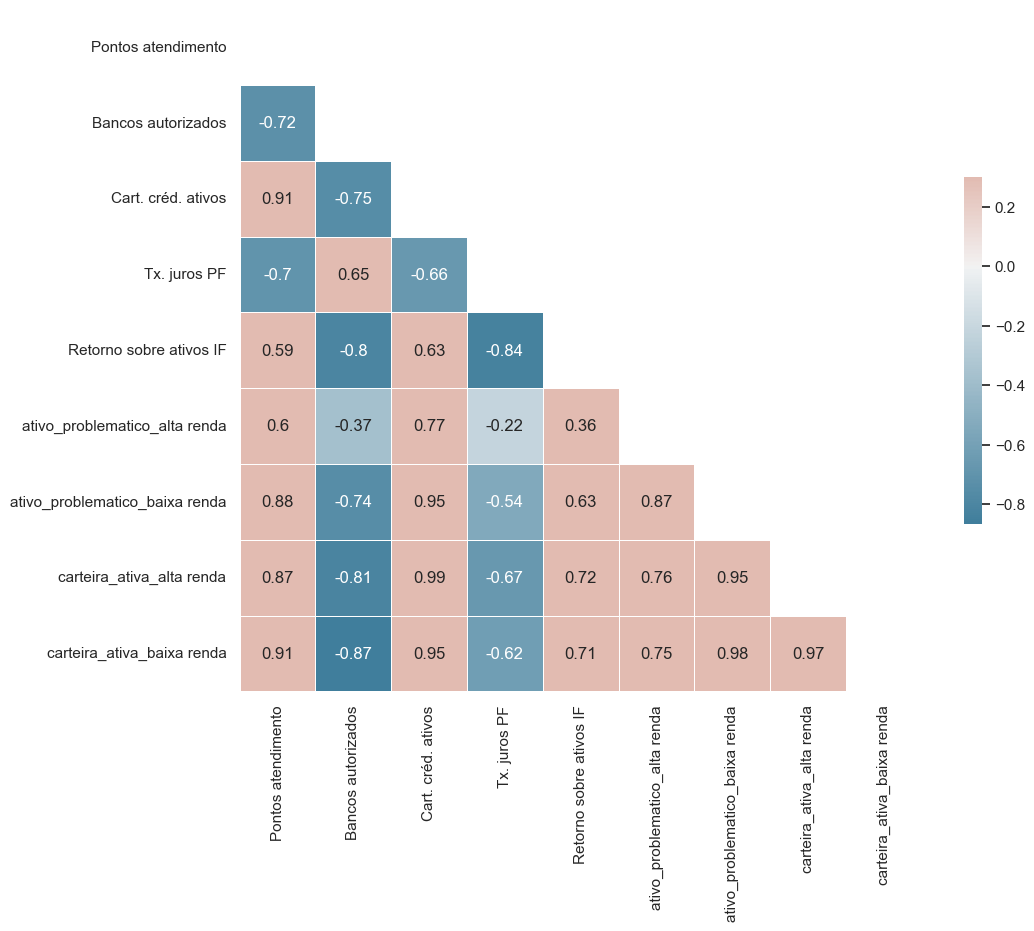

In [216]:
sns.set_theme(style="white")

corr = df_analise_porte_pf_num.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns_heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

In [203]:
df_analise_porte_pf_num.columns

Index(['Pontos atendimento', 'Bancos autorizados', 'Cart. créd. ativos',
       'Tx. juros PF', 'Retorno sobre ativos IF',
       'ativo_problematico_alta renda', 'ativo_problematico_baixa renda',
       'ativo_problematico_renda indisponível',
       'ativo_problematico_renda média', 'carteira_ativa_alta renda',
       'carteira_ativa_baixa renda', 'carteira_ativa_renda indisponível',
       'carteira_ativa_renda média'],
      dtype='object')

In [204]:
df_total.head(3)

,data_base,porte,carteira_ativa,ativo_problematico,mes,categoria_renda
0,2012,Acima de 20 salários mínimos,46133.02,0.00,12,alta renda
1,2012,Acima de 20 salários mínimos,2214767.68,53656.64,12,alta renda
2,2012,Acima de 20 salários mínimos,15534583.83,702980.73,12,alta renda


In [205]:
series_bacen_limpo.head(3)

,data,valor_24868,valor_24881,valor_25149,valor_20716,valor_29404
10,2015,153.0,1393.0,85.0,31.39,1.94
11,2016,154.0,1348.0,84.0,38.87,1.38
12,2017,152.0,1304.0,82.0,41.41,1.60


In [206]:
df_scatter_plot = pd.merge(series_bacen_limpo,
                              df_total,
                              left_on="data",
                              right_on="data_base",
                              how = "inner")

In [207]:
df_scatter_plot

,data,valor_24868,valor_24881,valor_25149,valor_20716,valor_29404,data_base,porte,carteira_ativa,ativo_problematico,mes,categoria_renda
0,2015,153.0,1393.0,85.0,31.39,1.94,2015,Acima de 20 salários mínimos,2751131.94,138056.97,12,alta renda
1,2015,153.0,1393.0,85.0,31.39,1.94,2015,Acima de 20 salários mínimos,18016204.14,276532.98,12,alta renda
2,2015,153.0,1393.0,85.0,31.39,1.94,2015,Acima de 20 salários mínimos,3234228.76,284526.54,12,alta renda
3,2015,153.0,1393.0,85.0,31.39,1.94,2015,Acima de 20 salários mínimos,1993889.92,159914.09,12,alta renda
4,2015,153.0,1393.0,85.0,31.39,1.94,2015,Acima de 20 salários mínimos,26299.92,19991.47,12,alta renda
...,...,...,...,...,...,...,...,...,...,...,...,...
774803,2022,159.0,1198.0,209.0,29.57,2.67,2022,Mais de 3 a 5 salários mínimos,41561.66,6457.38,12,alta renda
774804,2022,159.0,1198.0,209.0,29.57,2.67,2022,Mais de 5 a 10 salários mínimos,2267.87,0.00,12,renda média
774805,2022,159.0,1198.0,209.0,29.57,2.67,2022,Mais de 5 a 10 salários mínimos,308245.57,93732.71,12,renda média
774806,2022,159.0,1198.0,209.0,29.57,2.67,2022,Mais de 5 a 10 salários mínimos,180685.28,4842.19,12,renda média


In [208]:
df_scatter_plot = df_scatter_plot.rename(columns={
    'data': "ano",
    'valor_24868': "Pontos atendimento",
    'valor_24881': "Bancos autorizados",
    'valor_25149': "Cart. créd. ativos",
    'valor_20716': "Tx. juros PF",
    'valor_29404': "Retorno sobre ativos IF"
})

In [209]:
df_scatter_plot = df_scatter_plot.drop(columns = ['ano', 'data_base', 'mes'])

In [210]:
df_scatter_plot

,Pontos atendimento,Bancos autorizados,Cart. créd. ativos,Tx. juros PF,Retorno sobre ativos IF,porte,carteira_ativa,ativo_problematico,categoria_renda
0,153.0,1393.0,85.0,31.39,1.94,Acima de 20 salários mínimos,2751131.94,138056.97,alta renda
1,153.0,1393.0,85.0,31.39,1.94,Acima de 20 salários mínimos,18016204.14,276532.98,alta renda
2,153.0,1393.0,85.0,31.39,1.94,Acima de 20 salários mínimos,3234228.76,284526.54,alta renda
3,153.0,1393.0,85.0,31.39,1.94,Acima de 20 salários mínimos,1993889.92,159914.09,alta renda
4,153.0,1393.0,85.0,31.39,1.94,Acima de 20 salários mínimos,26299.92,19991.47,alta renda
...,...,...,...,...,...,...,...,...,...
774803,159.0,1198.0,209.0,29.57,2.67,Mais de 3 a 5 salários mínimos,41561.66,6457.38,alta renda
774804,159.0,1198.0,209.0,29.57,2.67,Mais de 5 a 10 salários mínimos,2267.87,0.00,renda média
774805,159.0,1198.0,209.0,29.57,2.67,Mais de 5 a 10 salários mínimos,308245.57,93732.71,renda média
774806,159.0,1198.0,209.0,29.57,2.67,Mais de 5 a 10 salários mínimos,180685.28,4842.19,renda média


In [218]:
valores_excluir = ['ativo_problematico_renda indisponivel', 
                   'ativo_problematico_renda média', 
                   'carteira_ativa_renda indisponível', 
                   'carteira_ativa_renda indisponível']

df_scatter_plot = df_scatter_plot[~df_scatter_plot['categoria_renda'].isin(valores_excluir)]

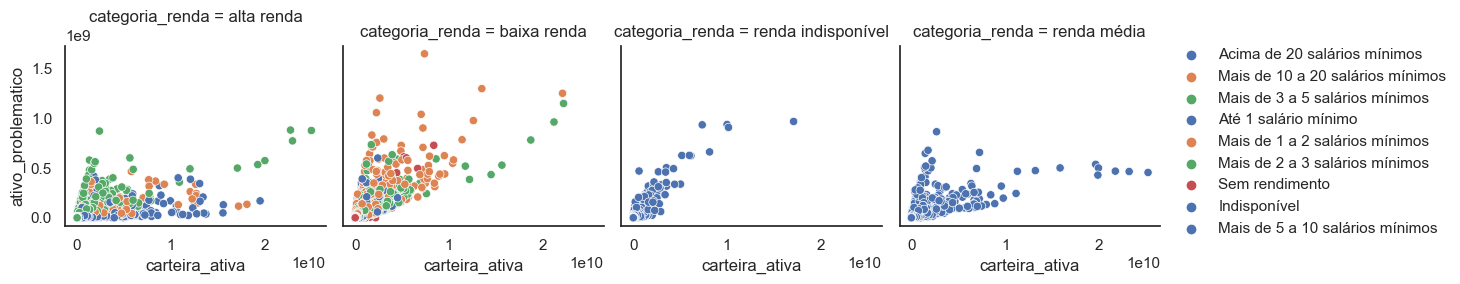

In [219]:
import warnings
warnings.filterwarnings('ignore')

g = sns.FacetGrid(df_scatter_plot, col = 'categoria_renda')
g.map_dataframe(sns.scatterplot, x="carteira_ativa", y="ativo_problematico", hue = "porte")
g.add_legend()